# Inventory Monitoring at Distribution Centers

With the rising cost (salaries, operation cost, human errors) of the workforce that is required for manual inventory management comes the need for more effective and cost-optimized inventory management methods.
Inventory management automation would eliminate a lot of human-related costs (operation/error costs) and one of the most state-of-the-art used techniques in Inventory management automation is Computer vision.
Computer vision enables real-time data collection via images and video collected by drones, phones, robots, and fixed cameras on shelves, in stores, and in warehouses. Computer vision-enabled software tracks stock detects damaged or mislabeled items, analyzes and forecasts peak- and off-peak demand for particular items and stores, and
even orders products from suppliers.
For years, computer vision has been transforming business solutions across industries, from self-driving cars to healthcare. Advances in this kind of artificial intelligence, which relies on machine learning (ML) models for object detection and recognition, have made computer vision competitive with human vision.

In [2]:
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.0 MB/s eta 0:00:0000:0100:01


In [3]:
!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 28.0 MB/s eta 0:00:0000:0100:01


In [26]:
!pip install smdebug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 3.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 1.2 MB/s eta 0:00:00:00:01


In [4]:
import argparse
import numpy as np
import json
import logging
import os
import io
import sys
import matplotlib.pyplot as plt
import requests
from PIL import Image
from tqdm import tqdm

In [5]:
import boto3
import torch
import sagemaker
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils import data
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

## Data Preparation

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [6]:
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

100%|██████████| 1228/1228 [01:38<00:00, 12.48it/s]


100%|██████████| 2299/2299 [02:59<00:00, 12.81it/s]


100%|██████████| 2666/2666 [03:35<00:00, 12.36it/s]


100%|██████████| 2373/2373 [03:10<00:00, 12.45it/s]


100%|██████████| 1875/1875 [02:27<00:00, 12.75it/s]


## Dataset
The Amazon Bin Image Dataset is to be used to train the model. It contains over 500,000 images and metadata from bins of a pod in an operating Amazon Fulfillment Center. The bin images in this dataset are captured as robot units carry pods as part of normal Amazon Fulfillment Center operations. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

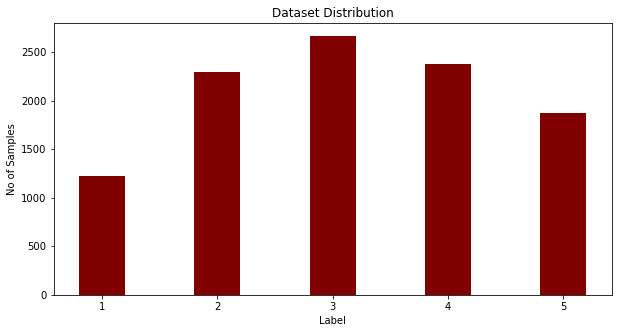

In [7]:
import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
data = {'1':1228, '2':2299, '3':2666,'4':2373, '5':1875}
object_count = list(data.keys())
no_of_samples = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(object_count, no_of_samples, color ='maroon',width = 0.4)

plt.xlabel("Label")
plt.ylabel("No of Samples")
plt.title("Dataset Distribution")
plt.show()

In [9]:
#TODO: Upload the data to AWS S3
!aws s3 cp train_data s3://inventory-monitoring/ --recursive

upload: train_data/1/00009.jpg to s3://inventory-monitoring/1/00009.jpg                
upload: train_data/1/00014.jpg to s3://inventory-monitoring/1/00014.jpg               
upload: train_data/1/00100.jpg to s3://inventory-monitoring/1/00100.jpg               
upload: train_data/1/00048.jpg to s3://inventory-monitoring/1/00048.jpg             
upload: train_data/1/00084.jpg to s3://inventory-monitoring/1/00084.jpg             
upload: train_data/1/00035.jpg to s3://inventory-monitoring/1/00035.jpg             
upload: train_data/1/00214.jpg to s3://inventory-monitoring/1/00214.jpg             
upload: train_data/1/00086.jpg to s3://inventory-monitoring/1/00086.jpg             
upload: train_data/1/00229.jpg to s3://inventory-monitoring/1/00229.jpg              
upload: train_data/1/00213.jpg to s3://inventory-monitoring/1/00213.jpg              
upload: train_data/1/00288.jpg to s3://inventory-monitoring/1/00288.jpg              
upload: train_data/1/00279.jpg to s3://inventory-monito

## Hyperparameter Tuning

In [6]:
os.environ['SM_CHANNEL_TRAIN']='s3://inventory-monitoring/'
os.environ['SM_MODEL_DIR']='s3://inventory-monitoring/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://inventory-monitoring/output/'

role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()

In [11]:
# Declare model training hyperparameter.
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128]),
    "epochs": CategoricalParameter([10,15, 25 , 30 ])
}

In [12]:
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [17]:
# Create training estimator
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    py_version='py3'
)

In [18]:
# Hyperparameter Tuning
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=4,
    objective_type=objective_type
)

In [ ]:
# TODO: Fit your estimator
tuner.fit({"training": "s3://inventory-monitoring/"})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..............................................................................................................................................................................................................................!


In [7]:
# Get the best estimators and the best HPs
TrainingJobName= 'pytorch-training-220910-1300-004-20a1b883'
best_estimator = sagemaker.estimator.Estimator.attach(TrainingJobName)

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-09-10 13:31:23 Starting - Preparing the instances for training
2022-09-10 13:31:23 Downloading - Downloading input data
2022-09-10 13:31:23 Training - Training image download completed. Training in progress.
2022-09-10 13:31:23 Uploading - Uploading generated training model
2022-09-10 13:31:23 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': 'Test Loss',
 'batch_size': '"128"',
 'epochs': '"25"',
 'learning_rate': '0.006011182711559713',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_hpo-2022-09-10-13-00-32-431"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-664382089581/pytorch_hpo-2022-09-10-13-00-32-431/source/sourcedir.tar.gz"'}

## Train model using best hyperparameter 

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [8]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'epochs': int(best_estimator.hyperparameters()['epochs'].replace('"', "")),
                      'learning_rate': best_estimator.hyperparameters()['learning_rate']}
print(f"Best Hyperparamters post Hyperparameter fine tuning are : \n {best_hyperparameters}")

Best Hyperparamters post Hyperparameter fine tuning are : 
 {'batch_size': 128, 'epochs': 25, 'learning_rate': '0.006011182711559713'}


In [23]:
# Setting up debugger and profiler rules and configs
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)


rules = [
    Rule.sagemaker(rule_configs.overfit()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [ ]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point="train.py",
    instance_count=4,
    instance_type="ml.m5.xlarge",
    role=role,
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

estimator.fit({'train' : "s3://inventory-monitoring/" },wait=True)

2022-09-11 09:37:38 Starting - Starting the training job...
2022-09-11 09:38:02 Starting - Preparing the instances for trainingOverfit: InProgress
ProfilerReport: InProgress
.........
2022-09-11 09:39:26 Downloading - Downloading input data...........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-09-11 09:41:25,534 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-09-11 09:41:25,537 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-09-11 09:41:25,550 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-09-11 09:41:25,553 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-09-11 09:41:26,026 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2022-09-11 09:41:26,026 sagemaker-containers INFO     Generating setup.

[2022-09-11 11:09:36.977 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:74 INFO s3_trial.py:42] Loading trial  at path s3://sagemaker-us-east-1-664382089581/pytorch-training-2022-09-11-09-37-37-817/debug-output/
[2022-09-11 11:09:37.376 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:74 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 214 more expected)', IncompleteRead(0 bytes read, 214 more expected)) while reading s3://sagemaker-us-east-1-664382089581/pytorch-training-2022-09-11-09-37-37-817/debug-output/index/000000000/000000000000_worker_0.json . Will retry now
[2022-09-11 11:09:41.500 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:74 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-09-11 11:09:42.526 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:74 INFO trial.py:210] Loaded all steps


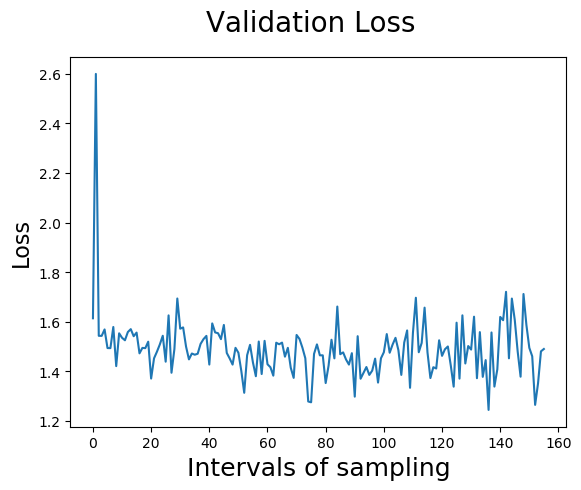

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

from smdebug.trials import create_trial
from smdebug import modes
import numpy as np
import matplotlib.pyplot as plt


# Get the tensors from S3
s3_output_path = 's3://sagemaker-us-east-1-664382089581/pytorch-training-2022-09-11-09-37-37-817/debug-output/'

# Create a Trial https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md#Trial
trial = create_trial(s3_output_path)

# Get all the tensor names
trial.tensor_names()

# Get the values of the tensor `val_acc`for mode GLOBAL (validation accuracy)
values = trial.tensor("CrossEntropyLoss_output_0").values(modes.GLOBAL)

# Convert it to numpy array
values_eval = np.array(list(values.items()))

fig = plt.figure()
plt.plot(values_eval[:, 1])
fig.suptitle('Validation Loss', fontsize=20)
plt.xlabel('Intervals of sampling', fontsize=18)
plt.ylabel('Loss', fontsize=16)
fig.savefig('validation_loss.jpg')

loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


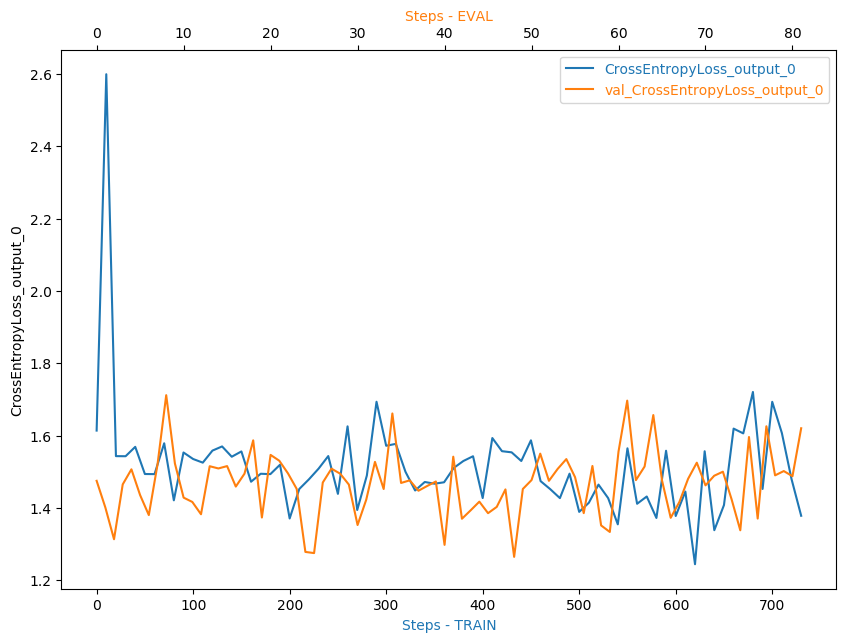

In [34]:
# TODO: Plot a debugging output.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from smdebug.core.modes import ModeKeys

#utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#plot tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps - TRAIN")
    par.set_xlabel("Steps - EVAL")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()
plot_tensor(trial, "CrossEntropyLoss_output_0")

## Profiler Report

In [35]:
# Display the profiler output
import os

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")
!aws s3 ls {rule_output_path} --recursive

## copy to local
!aws s3 cp {rule_output_path} ./ --recursive

You will find the profiler report in s3://sagemaker-us-east-1-664382089581/pytorch-training-2022-09-11-09-37-37-817/rule-output
2022-09-11 10:49:18     330767 pytorch-training-2022-09-11-09-37-37-817/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-09-11 10:49:18     172202 pytorch-training-2022-09-11-09-37-37-817/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-09-11 10:49:14        192 pytorch-training-2022-09-11-09-37-37-817/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-09-11 10:49:14        201 pytorch-training-2022-09-11-09-37-37-817/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-09-11 10:49:14        126 pytorch-training-2022-09-11-09-37-37-817/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-09-11 10:49:14        127 pytorch-training-2022-09-11-09-37-37-817/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.jso

In [36]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [38]:
model_location='s3://sagemaker-us-east-1-664382089581/pytorch-training-2022-09-11-09-37-37-817/output/model.tar.gz'

In [39]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [41]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [42]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

-----!

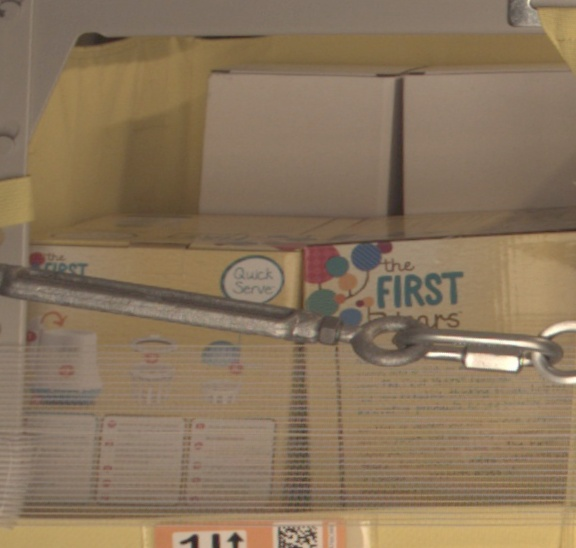

In [43]:
request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/900.jpg" }
img_bytes = requests.get(request_dict['url']).content
Image.open(io.BytesIO(img_bytes))

In [45]:
from IPython.display import Image
response=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [46]:
response[0]

[0.30879610776901245,
 0.21906228363513947,
 0.012726104818284512,
 -0.22806745767593384,
 -0.3999677896499634]

In [ ]:
np.argmax(response, 1)